In [1]:
import pandas as pd
import geopandas as gpd
from _bootstrap import *
from paths import get_paths

from community_detection import (
    MatrixConstructor,
    GraphConstructor,
    NXGraphConstructor,
    CommunityDetector,
    PolygonDissolver,
    GraphPlotter
)
input_dir, output_dir,  plots_dir = get_paths()

In [22]:
target_pop = 300

matrix = pd.read_parquet(output_dir / "matrices.parquet")

# Select matrix
matrix = matrix.loc[matrix["target_pop"]==target_pop].copy()

tracts = gpd.read_file(output_dir / "tracts.gpkg", layer=f"tracts_{target_pop}")

mc = MatrixConstructor(tracts_gdf=tracts,
                       patient_data_path= input_dir / 'synthetic_phc_consultations_2023.parquet',
                       locations_data_path= input_dir / 'synthetic_points.parquet', 
                       health_centres_path=input_dir / "Establecimientos DEIS MINSAL 29-04-2025.xlsx")
mc.load_tracts()
mc.load_patient_data()
mc.load_health_centres()

tracts["TractID"] = tracts["TractID"].astype(str)

matrix["TractID_1"] = matrix["TractID_1"].astype(int).astype(str)
matrix["TractID_2"] = matrix["TractID_2"].astype(int).astype(str)

gc = GraphConstructor(matrix, weights_col="visit_share")
gc.build_graph()
G = gc.get_graph()

In [24]:
# Assign each health centre to a TractID
centres_assignment = mc.assign_tracts(mc.health_centres, "care_cen_code", "TractID_2")
centres_assignment["TractID_2"] = centres_assignment["TractID_2"].astype(str)

matrix["TractID_2"] = matrix["TractID_2"].astype(float).astype(int).astype(str)

merge = matrix.merge(
    centres_assignment,
    on="TractID_2", how="left"
)
merge = merge[["TractID_2", "care_cen_code", "n_visits"]]

# Aggregate total visits per (care centre, TractID) pair
visits_by_centre_and_tract = (
    merge
    .groupby(["care_cen_code", "TractID_2"], as_index=False)["n_visits"]
    .sum()
)

In [29]:
cd = CommunityDetector(G, tracts, trials=30)
result, score, time = cd.run_infomap(return_codelength=True, preferred_modules=39, measure_time=True,
                                     enforce_spatial=True, strategy="strongest_connection", verbose=False)

df = pd.DataFrame(result.items(), columns=["TractID", "community"])

polygon_dissolver = PolygonDissolver(tracts)
pcsa = polygon_dissolver.process_community_outcomes(communities=df, verbose=False)
pcsa.head()

,commune_id,commune,community,pop,pop_high,pop_middle,pop_low,geometry
0,13201,PUENTE ALTO,1,69289,4133,31468,33688,"POLYGON ((353161.607 6279278.010, 353152.333 6..."
1,13201,PUENTE ALTO,2,87984,9486,49615,28883,"POLYGON ((353844.494 6281988.798, 353839.116 6..."
2,13110,LA FLORIDA,3,44211,1172,16740,26299,"POLYGON ((350352.737 6284165.231, 350352.065 6..."
3,13201,PUENTE ALTO,4,51153,1481,18304,31368,"POLYGON ((351588.900 6277190.600, 351588.714 6..."
4,13201,PUENTE ALTO,5,53291,2335,24237,26719,"POLYGON ((350843.602 6281765.156, 350843.595 6..."


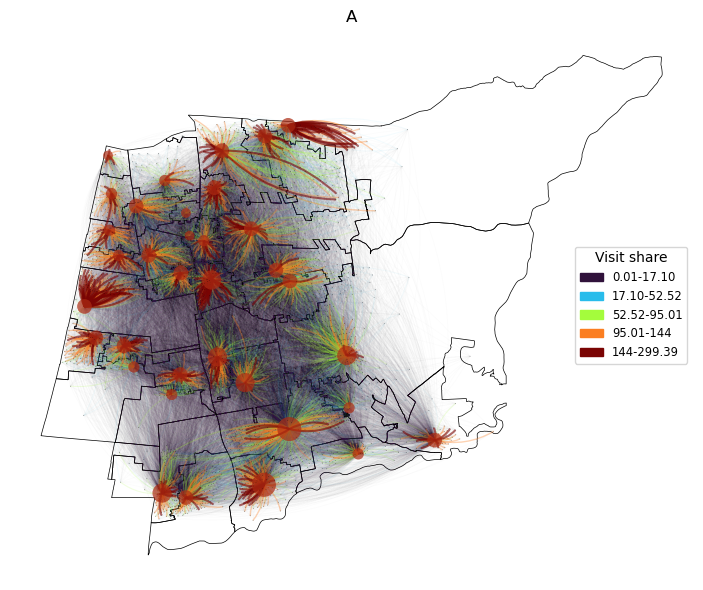

In [30]:
urb_comms = ['PUENTE ALTO', 'SAN RAMÓN', 'LA FLORIDA', 'LA PINTANA', 'LA GRANJA']
pcsa_urb = pcsa.loc[pcsa.commune.isin(urb_comms)]
geometry = pcsa_urb.dissolve().geometry.iloc[0]

gc = NXGraphConstructor(matrix, weights_col="visit_share")
gc.build_graph()
G = gc.get_graph()

plotter = GraphPlotter()
plotter.plot_graph(
      graph=G,
      bbox=geometry,
      polygon_gdf=pcsa_urb,
      weights_col="weight",
      edge_alpha_min=0.01,
      edge_alpha_max=0.6,
      edge_width_min=0.75,
      edge_width_max=1.5,
      cmap_name="turbo",
      node_size=0.15,
      vertex_color="black",
      add_basemap=False,
      polygon_edgecolor="black",
      polygon_linewidth=0.5,
      polygon_alpha=1,
      legend_title="Visit share",
      health_centre_df=visits_by_centre_and_tract,
      health_centre_id_col="TractID_2",
      health_centre_value_col="n_visits",
      health_node_color="#AB2B13",
      health_node_size_min=50,
      health_node_size_max=300,
      health_node_alpha=0.7,
      k_classes=5,
      figsize=(8, 6),
      zoom_to_nodes=False,
      title="A"
)

plotter.save_plot(plots_dir / "pcsas_and_flows_urban_communes.png", dpi=200)

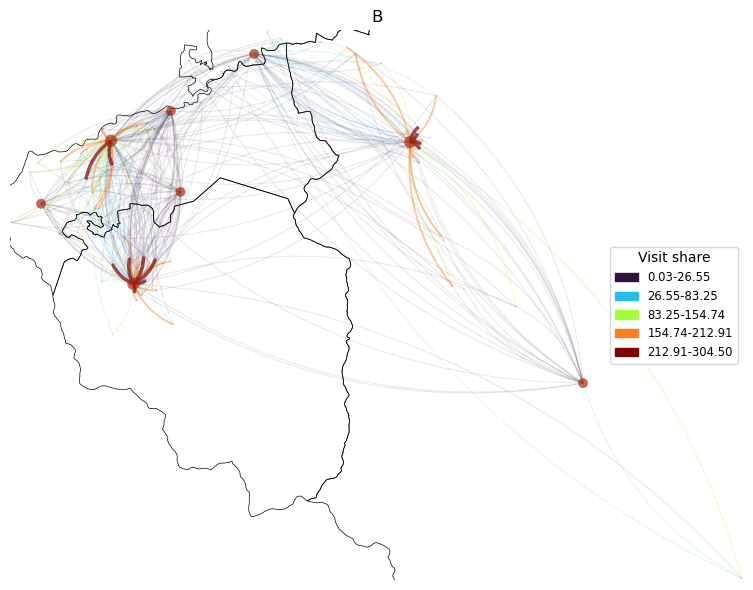

In [31]:
rur_comms = ['SAN JOSÉ DE MAIPO', 'PIRQUE']
pcsa_rur = pcsa.loc[pcsa.commune.isin(rur_comms)]
geometry = pcsa_rur.dissolve().geometry.iloc[0]

plotter.plot_graph(
      graph=G,
      bbox=geometry,
      polygon_gdf=pcsa_rur,
      weights_col="weight",
      edge_alpha_min=0.1,
      edge_alpha_max=0.7,
      edge_width_min=0.75,
      edge_width_max=2.5,
      cmap_name="turbo",
      node_size=0.15,
      vertex_color="black",
      add_basemap=False,
      polygon_edgecolor="black",
      polygon_linewidth=0.5,
      polygon_alpha=1,
      legend_title="Visit share",
      health_centre_df=visits_by_centre_and_tract,
      health_centre_id_col="TractID_2",
      health_centre_value_col="n_visits",
      health_node_color="#AB2B13",
      health_node_size_min=50,
      health_node_size_max=500,
      health_node_alpha=0.7,
      k_classes=5,
      figsize=(8, 6),
      zoom_to_nodes=True,
      title="B"
)

plotter.save_plot(plots_dir / "pcsas_and_flows_rural_communes.png", dpi=200)